CSE 546 - Reinfocement Learning
# Final course project
## Predicting stock price using Actor-critic method & time-series analysis

### Prerequisites

*Importing required libraries*

In [442]:
from google.colab import drive, files

import io, os, copy, math, random, datetime
from copy import deepcopy
from collections import deque, namedtuple

import numpy as np
import pandas as pd
pd.set_option('display.max_colwidth', 50)

import torch
from torch import nn, optim, autograd
from torch.nn import functional as F

import matplotlib
from matplotlib import pyplot as plt
%matplotlib inline

*Checking GPU availability*

In [443]:
DEVICE= torch.device('cuda' if torch.cuda.is_available() else 'cpu')

### Data (Environment)

In [444]:
class Data:
    def __init__(self, file_access: str, header: any, \
                 mode: str, file_path: str= None) -> None:
        '''
        Initiates the stock price environment

        Args:
            file_access: str - Mode of accessing the stock price data
            header: any - Availability of header in CSV file
            mode: str - Purpose of data - train (or) test
            file_path: str - Path of the CSV file (for local access only)
        '''

        self.file_access= file_access
        self.mode= mode

        if self.file_access == 'upload':
            io_file= self.get_upload()
            self.read(fl= io_file, header= header)
        elif self.file_access == 'drive':
            pass
        elif self.file_access == 'local':
            self.read(fl= file_path, header= header)

    def get_upload(self):
      '''
      Upload files from local machine
      '''

      if os.path.exists('/content/S&P 500 - Jan 05 to Mar 21.csv'):
          return '/content/S&P 500 - Jan 05 to Mar 21.csv'
      else:
          self.uploaded_file= files.upload()
          return io.BytesIO(self.uploaded_file\
                            [list(self.uploaded_file.keys())[0]])

    def link_drive(self) -> None:
      '''
      Link Gdrive to access .csv file
      '''
      # drive.mount()
      pass

    def read(self, fl: any, header: any) -> None:
        '''
        Reads raw CSV data from given path

        Args:
            path: str - Path to the data (.csv file)
            header: None/int - To mention the presence of header in csv
        '''

        self.data= pd.read_csv(fl, header= header)
        self.data= self.prepare(self.data)

    def prepare(self, data) -> np.array:
        '''
        Prepares data to a NN suitable format
        - Basically Exploratory Data Analysis (EDA)

        Arg:
            data: pd.DataFrame - Dataframe of raw data
        '''

        # Renaming columns
        data.rename(columns= {
            0: 'date', 
            1: 'open_price', 
            2: 'high_price', 
            3: 'low_price', 
            4: 'close_price', 
            5: 'adj_close_price', 
            6: 'share_volume'
        }, inplace= True)

        # Converting dates (in str format) to datetime format
        data['date']= pd.to_datetime(data['date'], format= '%d-%b-%y')

        # Seperating day, month, & year from date 
        # (easier for computation in network)
        data['day']= data['date'].dt.day
        data['month']= data['date'].dt.month
        data['year']= data['date'].dt.year

        # Delete date column
        del data['date']

        # Prepare all values in column for int/float formatting
        data= data.replace(',', '', regex= True)

        # Converts respective columns to float or int as required
        data['open_price']= pd.to_numeric(data['open_price'])
        data['high_price']= pd.to_numeric(data['high_price'])
        data['low_price']= pd.to_numeric(data['low_price'])
        data['close_price']= pd.to_numeric(data['close_price'])
        data['adj_close_price']= pd.to_numeric(data['adj_close_price'])
        data['share_volume']= pd.to_numeric(data['share_volume'])

        if self.mode == 'train':
            # Return 85% of data (i.e.) historical data for training
            final_data= data['close_price'].values
            n= round(final_data.shape[0]*0.85)
            return np.flip(final_data[-n:])
        elif self.mode == 'test':
            # Returns 15% of data (i.e.) recent data for testing
            final_data= data['close_price'].values
            n= round(final_data.shape[0]*0.15)
            return np.flip(final_data[:n])

    def sigmoid(self, x, y):
        '''
        Calculates sigmoid of x & y

        Args:
            x & y: float - Stock price
        '''

        return 1/(1 + math.exp(x - y))

    def get_state(self, w_data: list, w_start: int, 
                  w_end: int) -> np.array:
        '''
        Scales the stock price to 0-1 over a floating window

        Args:
            w_data: list - List of stock price
            w_start & w_end: int - Floating window limits
        '''

        # Floating window - Generates time-series
        if (w_start - w_end) >= -1:
            data= w_data[w_start - w_end + 1 : w_start + 1]
        else:
            data= (-1)*(w_start - w_end + 1)*[w_data[0]]
            data.extend(w_data[0: w_start + 1])
        
        # Exponential scaling
        scaled_data= list()
        for i in range(w_end - 1):
            scaled_data.append(self.sigmoid(
                x= data[i], 
                y= data[i+1]
                ))

        return np.array([scaled_data])

    @property
    def file_access(self):
        return self._file_access

    @file_access.setter
    def file_access(self, value):
        if isinstance(value, str) == False:
            raise TypeError('Invalid path')
        if value not in ['upload', 'drive', 'local']:
            raise ValueError('Access should be one of the following:\
                              Local, Drive, or Upload')
        self._file_access= value

    @property
    def mode(self):
      return self._mode

    @mode.setter
    def mode(self, value):
        if isinstance(value, str) == False:
            raise TypeError('Expected str, but received \
                             {}'.format(type(value)))
        if value not in ['train', 'test']:
            raise ValueError('Modes should be one of the \
                              following: \'train\' or \'test\'.')
        self._mode= value

### Actor-critic

In [445]:
class ACNet(nn.Module):
    def __init__(self, input_dim: int, output_dim: int, mode: str, 
                 n_hidden: int= 32, n_layers: int= 1) -> None:
        '''
        Initiates network for actor & critic

        Args:
            input_dim: int - Input dimension
            output_dim: int - Output dimension
            mode: str - Actor (or) Critic
            n_hidden: int - Number of nodes per hidden layer
            n_layers: int - Number of layers in NN
        '''

        super(ACNet, self).__init__()

        self.input_dim= input_dim
        self.n_hidden= n_hidden
        self.n_layers= n_layers
        self.output_dim= output_dim

        self.mode= mode

        self.build()

    def build(self) -> None:
        '''
        Builds Neural Network for given specification
        '''

        self.layers= list()
        for each_layer in range(self.n_layers):
            self.layers.append(nn.Linear(self.n_hidden, 
                                          self.n_hidden))
            self.layers.append(nn.BatchNorm1d(self.n_hidden))
            self.layers.append(nn.ReLU())

        # Build NN for actor
        if self.mode == 'actor':
            self.model= nn.Sequential(
                nn.Linear(self.input_dim, self.n_hidden), 
                nn.BatchNorm1d(self.n_hidden), 
                nn.ReLU(), 
                *self.layers, 
                nn.Linear(self.n_hidden, self.output_dim), 
                nn.BatchNorm1d(self.output_dim), 
                nn.ReLU()
            )

            # If GPU available, move model to GPU for faster processing
            if DEVICE == 'cuda': self.model.cuda()

        # Build NN for critic
        elif self.mode == 'critic':
            self.model= nn.Sequential(
                nn.Linear(self.input_dim, self.n_hidden), 
                nn.ReLU(), 
                *self.layers, 
                nn.Linear(self.n_hidden, 1)
            )

            # If GPU available, move model to GPU for faster processing
            if DEVICE == 'cuda': self.model.cuda()

        else:
            raise ValueError('Modes should be one of the \
                              following: \'actor\' or \'critic\'.')
            
        # Initializing optimizer
        self.optimizer= optim.Adam(self.model.parameters(), lr= 0.0001)

        # Initialize loss function
        self.loss_fn= nn.MSELoss()
      
    def forward(self, state: np.array):
        '''
        Predicts value for a given state

        Args:
            state: np.array - Array of state value (values within window)
        '''

        state= autograd.Variable(
            torch.from_numpy(state).float() #.unsqueeze(0)
            )

        if self.mode == 'actor':
            return self.model(state)
        elif self.mode == 'critic':
            return self.model(state)
        else:
            raise ValueError('Modes should be one of the \
                              following: \'actor\' or \'critic\'.')

    @property
    def mode(self):
      return self._mode

    @mode.setter
    def mode(self, value):
        if isinstance(value, str) == False:
            raise TypeError('Expected str, but received \
                             {}'.format(type(value)))
        if value not in ['actor', 'critic']:
            raise ValueError('Modes should be one of the \
                              following: \'actor\' or \'critic\'.')
        self._mode= value

### Agent

In [446]:
# Format to store experience
EXPERIENCE= namedtuple('experience', ['state', 'action',\
                                      'reward', 'next_state', 'done'])

# Replay buffer for the agent
class Memory:
    def __init__(self, volume: int= int(1e4)) -> None:
        '''
        Initiates memory buffer for the agent

        Args:
            volume: int - Size of memory
        '''

        self.volume= volume
        self.memory= deque(maxlen= self.volume)

    def memorize(self, experience: tuple) -> None:
        '''
        Stores experience to memory

        Args:
            experience: tuple - Tuple of state, action, 
                                reward, next state, & done
        '''
        self.memory.append(EXPERIENCE(experience))

    def sample(self, batch_size: int= 64) -> list:
        '''
        Samples a batch of experience from memory

        Args:
            batch_size: int - Number of experiences to be sampled
        '''
        return random.sample(self.memory, k= batch_size)

    def __len__(self) -> int:
        '''
        Returns the occupied memory size
        '''
        return len(self.memory)

    @property
    def volume(self):
        return self._volume

    @volume.setter
    def volume(self, value):
        if isinstance(value, int) == False:
            raise TypeError('int expected, instead received {}'.\
                            format(type(value)))
        if value < 0:
            raise ValueError('Memory capacity should be positive,\
                              instead received {}'.format(value))
        if value > int(1e6):
            raise ValueError('Maximum memory size is {}'.format(int(1e6)))
        self._volume= value

In [447]:
class Agent:
    def __init__(self, state_size: int, batch_size: int, 
                 mode: str= 'train', volume: int= int(1e4), 
                 eval: bool= False, discount_factor: float= 0.99, 
                 tau: float= 0.001) -> None:
        '''
        Initiates agent to learn environment

        Args:
            state_size: int - State size (i.e.) stock price window
            batch_size: int - Size of experience replay
            mode: str - Train (or) test
            volume: int - Size of the memory buffer
            eval: bool - Evaluation mode
            discount_factor: float - Rate of discount
            tau: float - For soft update of AC network
        '''

        self.state_size= state_size
        self.action_size= 3 # Buy, Sell, or Hold
        self.batch_size= batch_size

        self.mode= mode
        self.record= list()

        self.eval= eval
        self.gamma= discount_factor
        self.tau= tau

        # Initializing agent's memory
        self.volume= volume
        self.memory= Memory(volume= self.volume)

        # Estimating actor model
        self.actor_est= ACNet(
            input_dim= self.state_size, 
            output_dim= self.action_size, 
            mode= 'actor'
        )
        # Target actor model
        self.actor_tar= deepcopy(self.actor_est)

        # Estimating critic model
        self.critic_est= ACNet(
            input_dim= self.state_size, 
            output_dim= self.action_size, 
            mode= 'critic'
        )
        # Target critic model
        self.critic_tar= deepcopy(self.critic_est)

    def act(self, state: np.array):
        '''
        Chooses an action based on state

        Args:
            state: np.array - State array
        '''

        pred= self.actor_est.forward(state)
        self.prev_state= state
        if self.eval == False:
            return random.choice(range(self.action_size), p= pred[0])
        return np.argmax(pred[0])

    def step(self, observation: tuple):
        '''
        Gets action to be carried out at every step

        Args:
            observation: tuple - Contains prediction, reward, 
                                 next state, & done
        '''

        self.memory.memorize((self.prev_state, *observation))
        if len(self.memory) > self.batch_size:
            self.learn(self.memory.sample(self.batch_size))
            self.last_state= obervation[2] # Next state

    def learn(self, experiences: tuple):
        '''
        Learn form sampled experience

        Args:
            experiences: tuple - Contains state, action, 
            next_state, reward, & done
        '''

        state_np= np.vstack([i.state for i in experiences \
                             if i is not None]).astype(np.float)\
                             .reshape(-1, self.state_size)
        action_np= np.vstack([i.action for i in experiences \
                              if i is not None]).astype(np.float)\
                              .reshape(-1, self.action_size)
        reward_np= np.vstack([i.reward for i in experiences \
                              if i is not None]).astype(np.float)\
                              .reshape(-1, 1)
        done_np= np.vstack([i.done for i in experiences \
                            if i is not None]).astype(np.float)\
                            .reshape(-1, 1)
        next_state_np= np.vstack([i.next_state for i in \
                                  experiences if i is not None])\
                                  .astype(np.float)\
                                  .reshape(-1, self.state_size)

        next_action= self.actor_tar.forward(next_state_np)
        next_Q= self.critic_tar.forward([next_state_np, next_action])

        target_Q= reward_np + self.gamma * next_Q * (1 - done_np)
        self.critic_est.optimizer.step()
        self.actor_est.optimizer.step()
        self.soft_update(self.critic_est, self.critic_tar)
        self.soft_update(self.actor_est, self.actor_tar)

    def soft_update(self, model_est, model_tar):
        '''
        Performs soft update of model parameters

        Args:
            model_est - Estimating model
            model_tar - Target model
        '''

        est_weights= model_est.state_dict()
        tar_weights= model_tar.state_dict()

        if len(est_weights.values()) == len(tar_weights.values()):
            upd_weights= (self.tau*est_weights)+((1-self.tau)*tar_weights)
        else:
            raise Exception('Weight mismatch')

        model_tar.load_state_dict(upd_weights)

### Execution

In [448]:
class AgentRun:
    def __init__(self, env, batch_size: int= 64, 
                 window_size: int= 20) -> None:        
        self.env= env
        self.data= env.data
        
        self.batch_size= batch_size
        self.window_size= window_size

        self.agent= Agent(
            state_size= self.window_size, 
            batch_size= self.batch_size
        )

        self.max_timesteps= len(self.data) - 1

    def run(self, mode: str= 'train', max_episodes: int= 100, 
            verbose: bool= False):
        if mode == 'train':
          if verbose: print('Begin training')
          
          for each_episode in range(max_episodes):
              if verbose: print('Episode: {}/{}'\
                                    .format(each_episode, max_episodes))

              state= self.env.get_state(
                  w_data= self.data, 
                  w_start= 0, 
                  w_end= self.window_size + 1
              )

              self.agent.record= list()
              overall_profit= 0
              done= False
              for each_timestep in range(self.max_timesteps):
                  action= self.agent.act(state)
                  prob= self.agent.actor_est.forward(state)

                  next_state= self.env.get_state(
                      w_data= self.data, 
                      w_start= each_timestep + 1, 
                      w_end= self.window_size + 1
                  )

                  reward= 0

                  if action == 1:
                      self.agent.record.append(self.data[each_timestep])
                      pass

                  elif action == 2 and len(self.agent.record) > 0:
                      buy_price= self.agent.record.pop(0)
                      reward= max(self.data[each_timestep]-buy_price, 0)
                      overall_profit += self.data[each_timestep]-buy_price
                      if verbose: 
                          print('Sell: {} | Profit: {}'\
                                .format(self.data[each_timestep], 
                                      self.data[each_timestep]-buy_price))

                  if each_timestep == self.max_timesteps - 1:
                      done= True

                  self.agent.step((prob, reward, next_state, done))
                  state= next_state

                  if done:
                      print('Total profit: {}'.format(overall_profit))
        
        elif mode == 'test':
            overall_profit= 0
            
            state= self.env.get_state(
                w_data= self.data, 
                w_start= 0,
                w_end= self.window_size + 1
                )
            done= False

            self.agent.record= list()
            self.agent.eval= False
            for t in range(self.data.shape[0]):
                action= self.agent.act(state)

                next_state= self.env.get_state(
                    w_data= self.data, 
                    w_start= each_timestep + 1, 
                    w_end= self.window_size + 1
                    )
                reward= 0

                if action== 1:
                    self.agent.record.append(self.data[t])
                    if verbose: print('Buy: {}'.format(self.data[t]))
                
                elif action == 2 and len(self.agent.record) > 0:
                    buy_price= self.agent.record.pop(0)
                    reward= max(self.data[t]-buy_price, 0)
                    overall_profit += self.data[t]-buy_price
                    if verbose: print('Sell: {} | Profit: {}'\
                                      .format(self.data[t], 
                                              self.data[t]-buy_price))
                
                if t == len(self.data) - 2:
                    done= True
                
                self.agent.step((prob, reward, next_state, done))
                state= next_state

                if done:
                    print('Total profit: {}'.format(overall_profit))

        else:
            raise ValueError('Modes should be one of the \
                              following: \'train\' or \'test\'.')

#### Train

In [449]:
train_env= Data(
    file_access= 'upload', 
    header= None, 
    mode= 'train'
)

Training data - Market open days: 3473


Text(0, 0.5, 'Price in $')

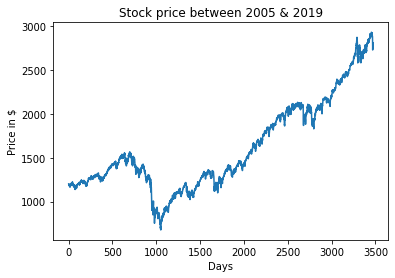

In [450]:
print('Training data - Market open days: {}'.format(train_env.data.shape[0]))
plt.plot(train_env.data) #4086 total
plt.title('Stock price between 2005 & 2019')
plt.xlabel('Days')
plt.ylabel('Price in $')

In [451]:
run_1= AgentRun(
    env= train_env
)

In [452]:
# run_1.run(
#     mode= 'train'
# )

In [453]:
test_env= Data(
    file_access= 'upload', 
    header= None, 
    mode= 'test'
)

Testing data - Market open days: 613


Text(0, 0.5, 'Price in $')

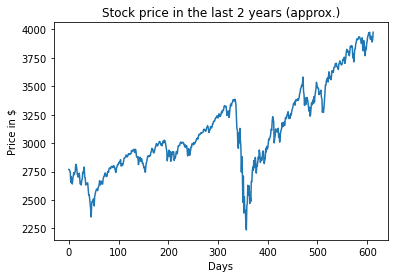

In [454]:
print('Testing data - Market open days: {}'.format(test_env.data.shape[0]))
plt.plot(test_env.data) #4086
plt.title('Stock price in the last 2 years (approx.)')
plt.xlabel('Days')
plt.ylabel('Price in $')

In [455]:
# run_1.env= test_env # Saving test data
# run_1.run(
#     mode= 'test'
# )